<a href="https://colab.research.google.com/github/crispitagorico/sigoptim/blob/main/mean_variance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classical mean variance optimisation

Let $P$ be a portfolio of assets $A_1,...,A_N$ with weights $\mathbf w = (w_1,...,w_N) \in \mathbb{R}^N$ and (random) returns $\mathbf r = (r_1,...,r_N) \in \mathbb{R}^N$. 

The portfolio total expected P&L is given by
$$\mathbf w^\top \mathbb E[\mathbf r] = \sum_{i=1}^N w_i \mathbb E[r_i].$$

Let $\Sigma = \mathbb E[(\mathbf r - \mathbb E[\mathbf r])(\mathbf r - \mathbb E[\mathbf r])^\top]$ be the covariance matrix of the returns.

The portfolio total risk is given by
$$\mathbf w^\top \Sigma \mathbf w = \sum_{i,j=1}^N w_i\Sigma_{i,j}w_j.$$

The mean-variance optimisation problem is formulated as follows
$$\min_{\mathbf w} \mathbf w^\top \Sigma \mathbf w \quad \text{ subject to } \ \mathbf w^\top \mathbb E[\mathbf r] = \mu, \quad \sum_{i=1}^Nw_i=1 \ \text{ and } \ 0 \leq w_i \leq 1,$$

where $\mu \in [0,\infty)$ is the expected P&L.

In [1]:
from itertools import product

import scipy
import iisignature
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sym
from tqdm import tqdm
from copy import copy
import math

from free_lie_algebra import *

In [2]:
def mean_variance_optim(expected_returns, covariance_matrix_returns, expected_pnl):

    # initialise weights
    N = expected_returns.size
    w0 = np.ones(N)

    # objective
    objective = lambda w: np.matmul(w.T, np.matmul(covariance_matrix_returns, w))

    # constraints
    bnds = tuple(N*[(0., 1.)])
    cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1.},
            {'type': 'eq', 'fun': lambda w: np.matmul(w.T, expected_returns) - expected_pnl})

    # run optimisation
    optim = scipy.optimize.minimize(fun=objective, x0=w0, bounds=bnds, constraints=cons)

    # return optimal weights 
    return optim.x

In [3]:
# number of assets
N = 10
w_size = 40

# stocks
df      = pd.read_csv('stocks.csv', index_col=0)
names   = df.columns[:N].to_list()
prices  = df.iloc[-w_size:, :N].to_numpy()
returns = np.diff(prices, axis=0)/prices[:-1, :]

# expected returns
expected_returns = np.mean(returns, axis=0)

# covariance matrix of returns
covariance_matrix_returns = np.cov(returns, rowvar=False)

# expected portfolio returns
expected_pnls = np.linspace(-0.002, 0.02, 50)

# optimal weights for given expected returns
optimal_weights = [mean_variance_optim(expected_returns, covariance_matrix_returns, pnl) for pnl in expected_pnls]

# actual portfolio P&L
pnls = [np.matmul(w.T, expected_returns) for w in optimal_weights]

# portfolio risk
risks = [np.matmul(w.T, np.matmul(covariance_matrix_returns, w)) for w in optimal_weights]

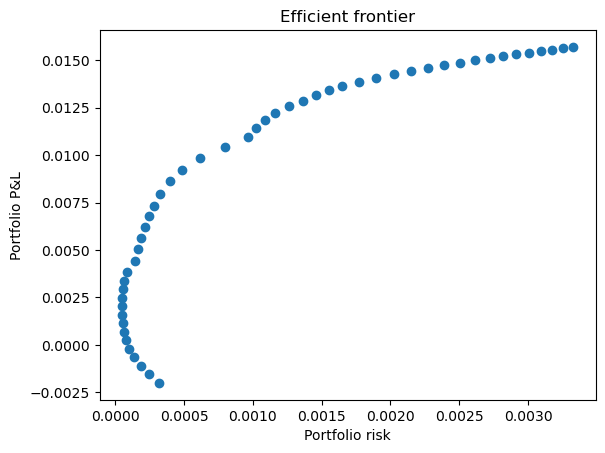

In [4]:
plt.scatter(risks, pnls)
plt.xlabel('Portfolio risk')
plt.ylabel('Portfolio P&L')
plt.title('Efficient frontier')
plt.show()

# Signature mean variance optimisation

Consider an $N$-dimensional price process $\mathbf S = (S^1,...,S^N) : [0,T] \to \mathbb{R}^N$. 

Consider $N$ linear functionals $\ell_i \in L(T^M(\mathbb{R}^N), \mathbb{R})$ for $i=1,...,N$ parameterised as

$$\ell_i = \sum_{|w| \leq M} \alpha^i_w w$$

Let $\ell = (\ell_1, ... ,\ell_N) \in L(T^M(\mathbb{R}^N), \mathbb{R}^N)$.

The expected P&L of a signature portfolio with weighting functional $\ell$ is given by

\begin{align}
\mathbb E \left[\int_0^T(\ell,S(X)_{0,t})^\top dX_t\right] &= \mathbb E \left[ \sum_{i=1}^N \int_0^T(\ell_i, S(X)_{0,t}) dX^i_t\right] \\
&= \mathbb E \left[ \sum_{i=1}^N \left(\ell_i \prec \mathbf i, S(X)_{0,T}\right)\right] \\
&= \sum_{i=1}^N \left(\ell_i \prec \mathbf i, \mathbb E \left[S(X)_{0,T}\right]\right)
\end{align}

where $\prec$ is the (right) half shuffle product (assuming paths start at $0$).

The portfolio total risk is given by

\begin{align}
& \mathbb E \left[\left(\int_0^T(\ell,S(X)_{0,t})^\top dX_t \right)^2\right] - \left(\mathbb E \left[\int_0^T(\ell,S(X)_{0,t})^\top dX_t \right]\right)^2\\
=& \ \mathbb E \left[ \sum_{i,j=1}^N \left(\ell_i \prec \mathbf i, S(X)_{0,T}\right)\left(\ell_j \prec \mathbf j, S(X)_{0,T}\right)\right] \\
& \quad - \sum_{i,j=1}^N  \left(\ell_i \prec \mathbf i, \mathbb E \left[S(X)_{0,T}\right]\right)\left(\ell_j \prec \mathbf j, \mathbb E \left[ S(X)_{0,T}\right]\right) \\
=&  \sum_{i,j=1}^N \left((\ell_i \prec \mathbf i) * (\ell_j \prec \mathbf j), \mathbb E \left[ S(X)_{0,T}\right]\right) -  \left(\ell_i \prec \mathbf i, \mathbb E \left[S(X)_{0,T}\right]\right)\left(\ell_j \prec \mathbf j, \mathbb E \left[ S(X)_{0,T}\right]\right)
\end{align}

where $*$ is the shuffle product.

The signature mean-variance optimisation problem is formulated as follows
$$\min_{\ell} \sum_{i,j=1}^N \left((\ell_i \prec \mathbf i) * (\ell_j \prec \mathbf j), \mathbb E \left[ S(X)_{0,T}\right]\right) -  \left(\ell_i \prec \mathbf i, \mathbb E \left[S(X)_{0,T}\right]\right)\left(\ell_j \prec \mathbf j, \mathbb E \left[ S(X)_{0,T}\right]\right)$$  

subject to 

$$\sum_{i=1}^N \left(\ell_i \prec \mathbf i, \mathbb E \left[S(X)_{0,T}\right]\right) = \mu$$

where $\mu \in [0,\infty)$ is the expected P&L, and expected constraints

$$\sum_{i=1}^N \left(\ell_i, \mathbb E \left[S(X)_{0,t}\right]\right) = 1, \quad t \in [0,T]$$

and 
$$ 0< \left(\ell_i, \mathbb E \left[S(X)_{0,t}\right]\right) < 1, \quad t \in [0,T], \quad i=1,...,N$$

We first define utility functions to perform the optimisation.

In [5]:
# Helper functions
# utility

def make_linear_functional(coeffs, d, n_):
    linear_functional = 0.*word2Elt('')
    
    for i, w in enumerate(wordIter(d, n_)):
        linear_functional += coeffs[i]*word2Elt(w)
        
    return linear_functional

def make_linear_functional_softmax(coeffs, d, n_):
    linear_functional = 0.*word2Elt('')
    
    for i, w in enumerate(wordIter(d, n_)):
        linear_functional += coeffs[i]*word2Elt(w)

    lf_orig = copy(linear_functional)

    for i in range(2, 10):
        linear_functional += shuffleProduct(linear_functional, lf_orig)
        
    return linear_functional

def ES(X, n_):
    """
    Calculates the expected signature associated to a bank of paths X, of shape N x l x d.
    
    :param X:  Bank of paths of shape N x l x d
    :param n_: Order of expected signature to take 
    
    :return:   Expected signature estimate of X
    
    """
    d     = X.shape[-1]
    sigX  = iisignature.sig(X, n_)
    esigX = np.array([1.] + list(np.mean(sigX, axis=0))) 
    return make_linear_functional(esigX, d, n_)

def make_ell_coeffs(N, n_, id_=""):
    prod_ = [i+1 for i in range(N)]
    
    a0    = ["a0" + id_]
    ais   = ['a' + ''.join(map(str, i)) + id_ for j in range(1, n+1) for i in product(prod_, repeat=j)]
    
    return sym.symbols(a0 + ais)

### Functions for the optimisation problem

def shuffle_power_prod(lf, sig, dim=10):
    res = 1
    for i in range(1, dim+1):
        res += (dotprod(lf, sig)**i)/(math.factorial(i))
    return res

# (l_i \preq i, S(X))
def integrate_linear_functional(ell, dim, sig):
    lpreqi = rightHalfShuffleProduct(ell, word2Elt(f'{dim+1}'))
    return dotprod(lpreqi, sig)

def integrate_linear_functional_shuffle(ell, dim, sig, d=10):
    lpreqi = rightHalfShuffleProduct(ell, word2Elt(f'{dim+1}'))
    return shuffle_power_prod(lpreqi, sig, dim=d)

# (l_i, S(X)) 
def get_weight(ell, sig):
    return dotprod(ell, sig)

# \sum_{i=1}^N (l_i, S(X))
def sum_weights(ells, sig):
    w_sum = 0
    for ell in ells:
        w_sum += get_weight(ell, sig)
        
    return w_sum

# Returns (l_i \preq i) * (l_j \preq j)
def variance_linear_functional(ell1, ell2, dim1, dim2):
    lpreqi = rightHalfShuffleProduct(ell1, word2Elt(f'{dim1+1}'))
    lpreqj = rightHalfShuffleProduct(ell2, word2Elt(f'{dim2+1}'))
    
    return shuffleProduct(lpreqi, lpreqj)
                                     

# \sum_{i=1}^N (l_i \preq i, S(X))
def portfolio_return(ells, sig):
    mu = 0
    for dim, ell in enumerate(ells):
        mu += integrate_linear_functional(ell, dim, sig)
        
    return mu



def portfolio_variance(ells, sig):
    """
    Implements Eq 7
    """
    var = 0
    for dim1, ell1 in enumerate(ells):
        for dim2, ell2 in enumerate(ells):
            crossvar = shuffle_power_prod(variance_linear_functional(ell1, ell2, dim1, dim2), sig)
            mean1    = integrate_linear_functional_shuffle(ell1, dim1, sig)
            mean2    = integrate_linear_functional_shuffle(ell2, dim2, sig)
            var     += crossvar - mean1*mean2
            
    return var
    

We now build our required functions and write these as symbolic expressions.

In [6]:
# Hyperparameters. Main one is the expected signature order to take (and thus on the linear functionals). 
# Since we take a shuffle product, the expected signature order will need to be 2 times this number.
n = 0

# We first define each of the l_i's
ell_coeffs  = [make_ell_coeffs(N, n, "^" + str(i+1)) for i in range(N)]
ells        = [make_linear_functional(ell_coeff, N, n) for ell_coeff in ell_coeffs]

# Build the expected signature (from data, for now). normalise prices to start at 0
#norm_prices =  prices - np.tile(np.expand_dims(prices[0], axis=0), (w_size, 1))
norm_prices = prices/prices[0] - 1
esig        = ES(np.expand_dims(norm_prices, 0), 2*(n+1))

In [7]:
# General wrapper to interface with scipy
def function_wrapper(func):
    def _wrapper(val):
        if len(val.shape) == 1:
            val = np.expand_dims(val, 1)
        return func(val)
    return _wrapper


# Lambdify optimising functional
variance_polynomial_ = portfolio_variance(ells, esig)
variance_polynomial  = sym.lambdify([ell_coeffs], variance_polynomial_)

@function_wrapper
def variance_function(a):
    return variance_polynomial(a)



In [8]:
# Need to lambdify constraints too 
return_polynomial_ = portfolio_return(ells, esig)
return_polynomial  = sym.lambdify([ell_coeffs], return_polynomial_)

weight_sum_polynomial_= sum_weights(ells, esig)
weight_sum_polynomial = sym.lambdify([ell_coeffs], weight_sum_polynomial_)

def get_weight_list(ells, sig):
    return [dotprod(ell, sig) for ell in ells]

def weight_check(ells, sig):
    w_check = 0
    for ell in ells:
        # print(type(dotprod(ell, sig)))
        if 0 < get_weight(ell, sig) < 1:
            pass
        else:
            w_check += 1
        
    return w_check

weight_list_poly_ = get_weight_list(ells, esig)
weight_list_poly = sym.lambdify([ell_coeffs], weight_list_poly_)

def test_list(a):
    upper = [i < 1 for i in a]
    lower = [i > 0 for i in a]
    res = np.array(upper) * np.array(lower)
    return 1 - res.prod()

@function_wrapper
def weight_list_function(a):
    # print(test_list(weight_list_poly(a)))
    return test_list(weight_list_poly(a))

@function_wrapper
def return_function(a):
    return return_polynomial(a)

@function_wrapper
def weight_sum_function(a):
    return weight_sum_polynomial(a)

def modified_var(a, exp_pnl=0, pen=1e100):
    pens = pen * (np.allclose([weight_sum_function(a)], [1], atol=1e-5, rtol=0)) +\
           pen * (np.allclose([weight_list_function(a)], [0], atol=1e-5, rtol=0)) +\
           pen * (np.allclose([return_function(a)], [exp_pnl], atol=1e-3, rtol=0))
    res = variance_function(a) - pens
    return res

Optimiser for the signature mean-variance problem.

In [9]:
# Potentially you can pre-derive bounds on the weights?

# print(weight_list_function(np.array([0.5, 0.3, 0.6] + list(np.ones(7)/N))))

def signature_mean_variance_optim(expected_pnl):
    N = np.array(ell_coeffs).shape[0]
    w0 = np.ones(N)/N
    assert weight_list_function(w0) == 0
    # np.testing.assert_almost_equal(weight_sum_function(w0), 1, decimal=6)

    # def modified_var(a, exp_pnl=expected_pnl, pen=1e100):
    #     pens = pen * ~(np.allclose([weight_sum_function(a)], [1], atol=1e-6, rtol=0)) +\
    #            pen * ~(np.allclose([weight_list_function(a)], [0], atol=1e-6, rtol=0)) +\
    #            pen * ~(np.allclose([return_function(a)], [exp_pnl], atol=1e-6, rtol=0))
    #     res = variance_function(a) - pens
    #     return res

    bnds = tuple(N*[(-100., 100.)])
    # w_sum_1 = scipy.optimize.NonlinearConstraint(fun=lambda w: weight_sum_function(w) - 1., lb=-1e-6, ub=1e-6)
    # ret_pnl = scipy.optimize.NonlinearConstraint(fun=lambda w: return_function(w) - expected_pnl, lb=-1e-3, ub=1e-3)
    # list_test = scipy.optimize.NonlinearConstraint(fun=lambda w: weight_list_function(w), lb=0, ub=0)
    # # cons = ({'type': 'eq', 'fun': lambda w: weight_sum_function(w) - 1.},
    # #         {'type': 'eq', 'fun': lambda w: return_function(w) - expected_pnl},
    # #         {'type': 'eq', 'fun': lambda w: weight_list_function(w)}
    #        # )
    # cons = (w_sum_1, ret_pnl, list_test)
    # pre_cons = (w_sum_1, list_test)

    # # pre_optim = scipy.optimize.minimize(fun=lambda w: abs(return_function(w) - expected_pnl),
    # #                                     x0=w0,
    # #                                     constraints=pre_cons,
    # #                                     bounds=bnds,
    # #                                     method='trust-constr'
    # #                                     )

    # pre_optim = scipy.optimize.differential_evolution(func=lambda w: abs(return_function(w) - expected_pnl),
    #                                                   # x0=w0,
    #                                                   constraints=cons,
    #                                                   bounds=bnds,
    #                                                   maxiter=200,
    #                                                   # polish=False
    #                                                   )

    # # np.testing.assert_almost_equal(weight_list_function(pre_optim.x), 1, decimal=6)
    # # np.testing.assert_almost_equal(weight_sum_function(pre_optim.x), 1, decimal=6)

    # # print(pre_optim.x)
    # try:
    #     np.testing.assert_almost_equal(return_function(pre_optim.x), expected_pnl, decimal=3)
    # except AssertionError:
    #     print("Needs more iterations")
    #     pre_optim = scipy.optimize.differential_evolution(func=lambda w: abs(return_function(w) - expected_pnl),
    #                                               # x0=w0,
    #                                               constraints=cons,
    #                                               bounds=bnds,
    #                                               maxiter=1000,
    #                                               # polish=False
    #                                               )

    # try:
    #     np.testing.assert_almost_equal(return_function(pre_optim.x), expected_pnl, decimal=3)
    # except AssertionError:
    #     print(f"Failed to find close enough return function for pnl = {expected_pnl}")
    
    # optim = scipy.optimize.differential_evolution(func=modified_var,
    #                                               # x0=w0,
    #                                               # constraints=cons,
    #                                               bounds=bnds,
    #                                               polish=False,
    #                                               )

    optim = scipy.optimize.minimize(variance_function,
                                    # pre_optim.x,
                                    w0,
                                    # constraints=cons,
                                    # bounds=bnds,
                                    # method='trust-constr'
                                    method='Nelder-Mead'
                                    )

    print(modified_var(optim.x))
    try:
        np.testing.assert_almost_equal(weight_sum_function(optim.x), 1, decimal=6)
    except:
        print(f"Sum Failed = {weight_sum_function(optim.x)}")

    try:
        np.testing.assert_almost_equal(weight_list_function(optim.x), 1, decimal=6)
    except:
        print(f"List Failed = {weight_list_function(optim.x)}")

    
    try:
        np.testing.assert_almost_equal(return_function(optim.x), expected_pnl, decimal=3)
    except:
        print(f"PNL Failed = {return_function(optim.x)}")
                    
    return optim.x

Build efficient frontier.

In [10]:
pnls     = np.linspace(0., 0.1, 20)

ellstars = []
for pnl in tqdm(pnls):
    ellstars.append(signature_mean_variance_optim(pnl))

print(np.array(ellstars).shape)
risks = [variance_function(ell) for ell in ellstars]

# ellstars_lf = [make_linear_functional(i, N, n) for i in ellstars]
# risks = [variance_linear_functional(ell, esig, N, N) for ell in ellstars_lf]

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]<lambdifygenerated-1>:3: RuntimeWarning: overflow encountered in scalar power
  return 6.3748467714658e-32*Dummy_36**20 + 1.85372997263375e-28*Dummy_36**18 + 4.8513845762375e-25*Dummy_36**16 + 1.12858016139286e-21*Dummy_36**14 + 2.29724425180014e-18*Dummy_36**12 + 1.16340531716948e-34*Dummy_36**10*Dummy_37**10 + 5.31985040016409e-32*Dummy_36**10*Dummy_38**10 + 5.22067023823731e-32*Dummy_36**10*Dummy_39**10 + 2.63238821216551e-28*Dummy_36**10*Dummy_40**10 + 7.7079060482567e-30*Dummy_36**10*Dummy_41**10 + 1.24396844010667e-32*Dummy_36**10*Dummy_42**10 + 8.07846656999935e-33*Dummy_36**10*Dummy_43**10 + 3.90557144989637e-27*Dummy_36**10*Dummy_45**10 + 4.00796296035443e-15*Dummy_36**10 + 6.81215680525131e-31*Dummy_36**9*Dummy_37**9 + 1.68824772811316e-28*Dummy_36**9*Dummy_38**9 - 1.65989391209716e-28*Dummy_36**9*Dummy_39**9 + 3.56813797749452e-25*Dummy_36**9*Dummy_40**9 + 1

-6.909670858157748e+274
Sum Failed = -470729059777985.75
PNL Failed = 441908231523459.2


 10%|████████▎                                                                          | 2/20 [00:01<00:12,  1.44it/s]

-6.909670858157748e+274
Sum Failed = -470729059777985.75
PNL Failed = 441908231523459.2


 15%|████████████▍                                                                      | 3/20 [00:02<00:12,  1.33it/s]

-6.909670858157748e+274
Sum Failed = -470729059777985.75
PNL Failed = 441908231523459.2


 20%|████████████████▌                                                                  | 4/20 [00:03<00:14,  1.09it/s]

-6.909670858157748e+274
Sum Failed = -470729059777985.75
PNL Failed = 441908231523459.2


 25%|████████████████████▊                                                              | 5/20 [00:04<00:14,  1.00it/s]

-6.909670858157748e+274
Sum Failed = -470729059777985.75
PNL Failed = 441908231523459.2


 30%|████████████████████████▉                                                          | 6/20 [00:05<00:14,  1.06s/it]

-6.909670858157748e+274
Sum Failed = -470729059777985.75
PNL Failed = 441908231523459.2


 35%|█████████████████████████████                                                      | 7/20 [00:06<00:14,  1.10s/it]

-6.909670858157748e+274
Sum Failed = -470729059777985.75
PNL Failed = 441908231523459.2


 40%|█████████████████████████████████▏                                                 | 8/20 [00:08<00:13,  1.11s/it]

-6.909670858157748e+274
Sum Failed = -470729059777985.75
PNL Failed = 441908231523459.2


 45%|█████████████████████████████████████▎                                             | 9/20 [00:09<00:12,  1.11s/it]

-6.909670858157748e+274
Sum Failed = -470729059777985.75
PNL Failed = 441908231523459.2


 50%|█████████████████████████████████████████                                         | 10/20 [00:10<00:11,  1.12s/it]

-6.909670858157748e+274
Sum Failed = -470729059777985.75
PNL Failed = 441908231523459.2


 55%|█████████████████████████████████████████████                                     | 11/20 [00:11<00:10,  1.12s/it]

-6.909670858157748e+274
Sum Failed = -470729059777985.75
PNL Failed = 441908231523459.2


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:12<00:08,  1.12s/it]

-6.909670858157748e+274
Sum Failed = -470729059777985.75
PNL Failed = 441908231523459.2


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:13<00:07,  1.13s/it]

-6.909670858157748e+274
Sum Failed = -470729059777985.75
PNL Failed = 441908231523459.2


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:14<00:06,  1.15s/it]

-6.909670858157748e+274
Sum Failed = -470729059777985.75
PNL Failed = 441908231523459.2


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:16<00:05,  1.17s/it]

-6.909670858157748e+274
Sum Failed = -470729059777985.75
PNL Failed = 441908231523459.2


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:17<00:04,  1.17s/it]

-6.909670858157748e+274
Sum Failed = -470729059777985.75
PNL Failed = 441908231523459.2


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:18<00:03,  1.15s/it]

-6.909670858157748e+274
Sum Failed = -470729059777985.75
PNL Failed = 441908231523459.2


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:19<00:02,  1.16s/it]

-6.909670858157748e+274
Sum Failed = -470729059777985.75
PNL Failed = 441908231523459.2


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:20<00:01,  1.17s/it]

-6.909670858157748e+274
Sum Failed = -470729059777985.75
PNL Failed = 441908231523459.2


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.10s/it]

-6.909670858157748e+274
Sum Failed = -470729059777985.75
PNL Failed = 441908231523459.2
(20, 10)


# 

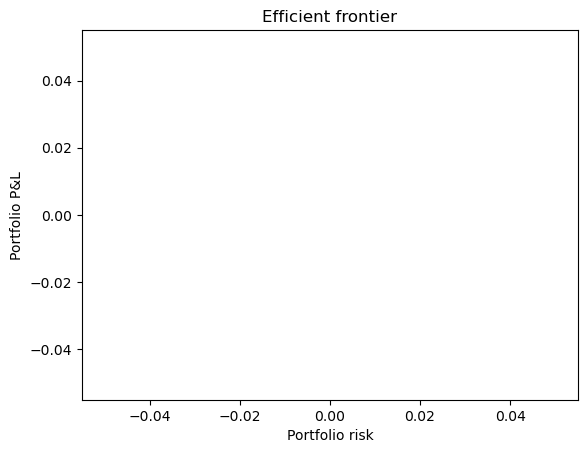

In [11]:
# print(risks.shape)
filtered_risks = []
risk_inds = []
for ind, val in enumerate(risks):
    if val >= -1:
        risk_inds.append(ind)
        filtered_risks.append(val)

filtered_pnls = [pnls[x] for x in risk_inds]
plt.scatter(filtered_risks, filtered_pnls)
plt.xlabel('Portfolio risk')
plt.ylabel('Portfolio P&L')
plt.title('Efficient frontier')
plt.show()

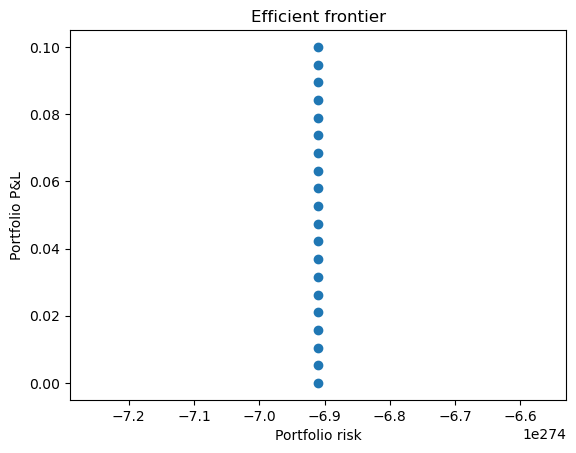

In [12]:
plt.scatter(risks, pnls)
plt.xlabel('Portfolio risk')
plt.ylabel('Portfolio P&L')
plt.title('Efficient frontier')
plt.show()